Here, we will be building a DANN.

In [2]:
#importing modules
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, Model
import time
import matplotlib.pyplot as plt
import numpy as np
import keras as K
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.layers import Dense
import pandas as pd

from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical


In [3]:

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

Preprocessing Target Domain Dataset

In [4]:
# Replace 'your_file_path.csv' with the actual path to your CSV file
file_path = 'datasets/target/recipes_serp_youtube_data.csv'

# Read the CSV file into a Pandas DataFrame
df_target = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to check the data
print(df_target.head())

             q                         queryTime  rank  \
0  dish recipe  2019-03-30 02:55:42.169989+00:00     1   
1  dish recipe  2019-03-30 02:55:42.169989+00:00     2   
2  dish recipe  2019-03-30 02:55:42.169989+00:00     3   
3  dish recipe  2019-03-30 02:55:42.169989+00:00     4   
4  dish recipe  2019-03-30 02:55:42.169989+00:00     5   

                                               title  \
0                             7 Easy Chicken Dinners   
1  KING of VEGETABLE Recipe | SAMBAR Recipe with ...   
2  ALOO Manchurian Recipe How to make aloo manchu...   
3  सूजी का इतना टेस्टी और आसान नाश्ता की आप रोज़ ...   
4  5 मिनट में बनाये कुरकुरे आलू स्नैक्स | Aloo Sn...   

                                         description  \
0  Customize & buy the Tasty Cookbook here: http:...   
1  Today we cooking one of the most popular veg r...   
2  ldli Manchurian Recipe https://youtu.be/wx7Mx9...   
3  Hello Friend's ….Aaj Main Aapko Quick & Easy B...   
4  If you liked the video give it 

In [4]:
df_target.columns

Index(['q', 'queryTime', 'rank', 'title', 'description', 'publishedAt',
       'channelTitle', 'totalResults', 'kind', 'channelId', 'default.height',
       'default.url', 'default.width', 'high.height', 'high.url', 'high.width',
       'liveBroadcastContent', 'medium.height', 'medium.url', 'medium.width',
       'nextPageToken', 'playlistId', 'resultsPerPage', 'thumbnails',
       'videoId', 'video.contentDetails', 'video.etag', 'video.id',
       'video.kind', 'video.localizations', 'video.player',
       'video.recordingDetails', 'video.snippet', 'video.statistics',
       'video.status', 'video.topicDetails', 'video.categoryId',
       'video.channelId', 'video.channelTitle', 'video.defaultAudioLanguage',
       'video.defaultLanguage', 'video.description',
       'video.liveBroadcastContent', 'video.localized', 'video.publishedAt',
       'video.tags', 'video.thumbnails', 'video.title',
       'video.relevantTopicIds', 'video.topicCategories', 'video.topicIds',
       'video.comme

In [5]:
#here we will only be using 'title' and 'video.tags' for our purpose
#if you want to do DANN, use 'description' column as well so that the recipe & description are relevant to have similar features
#so we will be dropping the remaining columns
df_target = df_target.drop(columns=['q', 'queryTime', 'description','rank', 'publishedAt', 'channelTitle', 'totalResults', 'kind', 'channelId', 'default.height', 'default.url', 'default.width', 'high.height', 'high.url', 'high.width', 'liveBroadcastContent', 'medium.height', 'medium.url', 'medium.width', 'nextPageToken', 'playlistId', 'resultsPerPage', 'thumbnails', 'videoId', 'video.contentDetails', 'video.etag', 'video.id', 'video.kind', 'video.localizations', 'video.player', 'video.recordingDetails', 'video.snippet', 'video.statistics', 'video.status', 'video.topicDetails', 'video.categoryId', 'video.channelId', 'video.channelTitle', 'video.defaultAudioLanguage', 'video.defaultLanguage', 'video.description', 'video.liveBroadcastContent', 'video.localized', 'video.publishedAt', 'video.thumbnails', 'video.title', 'video.relevantTopicIds', 'video.topicCategories', 'video.topicIds', 'video.commentCount', 'video.dislikeCount', 'video.favoriteCount', 'video.likeCount', 'video.viewCount', 'video.embeddable', 'video.license', 'video.privacyStatus', 'video.publicStatsViewable', 'video.uploadStatus', 'video.caption', 'video.definition', 'video.dimension', 'video.duration', 'video.licensedContent', 'video.projection', 'video.regionRestriction', 'video.liveStreamingDetails', 'video.contentRating', 'channel.contentDetails', 'channel.etag', 'channel.id', 'channel.kind', 'channel.snippet', 'channel.statistics', 'channel.country', 'channel.customUrl', 'channel.defaultLanguage', 'channel.description', 'channel.localized', 'channel.publishedAt', 'channel.thumbnails', 'channel.title', 'channel.commentCount', 'channel.hiddenSubscriberCount', 'channel.subscriberCount', 'channel.videoCount', 'channel.viewCount', 'channel.relatedPlaylists'])

In [6]:
df_target.columns

Index(['title', 'video.tags'], dtype='object')

In [6]:
# Assuming df['video.tags'] is your text data
df_target['video.tags'].fillna('', inplace=True)  # Replace NaN values with an empty string


In [8]:
type(df_target['video.tags'][0])

str

In [7]:
#here we are creating a labels for target domain because the dataset does not have labels
#1/3 part of the labels to 'appetizers'. another 1/3 part to 'dinner' and the last 1/3 part to 'desserts'

total_size = len(df_target)
category_size = total_size // 3
df_target['labels'] = None
df_target.loc[:category_size - 1, 'labels'] = 'Appetizers'
df_target.loc[category_size:2*category_size - 1, 'labels'] = 'Dinner'
df_target.loc[2*category_size:total_size - 1, 'labels'] = 'Desserts'

In [10]:
df_target.head

<bound method NDFrame.head of                                                   title  \
0                                7 Easy Chicken Dinners   
1     KING of VEGETABLE Recipe | SAMBAR Recipe with ...   
2     ALOO Manchurian Recipe How to make aloo manchu...   
3     सूजी का इतना टेस्टी और आसान नाश्ता की आप रोज़ ...   
4     5 मिनट में बनाये कुरकुरे आलू स्नैक्स | Aloo Sn...   
...                                                 ...   
1450                                    How to make pho   
1451  Easy PHO 3 Ways! Beef, Chicken, Veggie (Vietna...   
1452                                  Masterchef sadza.   
1453  মিষ্টি দই বানানোর সহজ রেসিপি || How to make Sw...   
1454  ১ ঘন্টায় চুলায় তৈরী বগুড়ার ঐতিহ্যবাহী মিষ্ট...   

                                             video.tags      labels  
0     ['chicken', 'dinner', 'tasty', 'buzzfeed', 'qu...  Appetizers  
1     ['vegetable', 'vegetable recipe', 'sambar reci...  Appetizers  
2                                                  

In [8]:
#shuffling the dataframe
df_target = df_target.sample(frac=1, random_state=42)

In [13]:
df_target.head

<bound method NDFrame.head of                                                   title  \
497   Cooking &amp; Tasting Pork Belly Curry In My V...   
1261                            How to Make a Braai Pie   
411   Beef &amp; Guinness Stew - St. Patrick&#39;s D...   
1046                  How to Make a Perfect Ratatouille   
1033    How to make an Authentic bowl of VIETNAMESE PHO   
...                                                 ...   
1095                  Handle It - The Universal Poutine   
1130  Super Simple Succotash -- Ridiculousy Easy &am...   
1294  Jamaican Saltfish Fritters Recipe 2016 | Recip...   
860   Authentic Spanish Seafood Paella Recipe - Cola...   
1126          Ful Mudammas (Fuul) Ful Mudammas فول مدمس   

                                             video.tags      labels  
497   ['pork recipe', 'pork', 'pork belly', 'cooking...      Dinner  
1261  ['Cooking (Interest)', 'How-to (Website Catego...    Desserts  
411   ['Beef', 'Stew', 'Guinness', "St. Patrick's D

Preprocessing the auxiliary dataset

In [9]:
# Replace 'your_file_path.csv' with the actual path to your CSV file
file_path = 'datasets/source/kaggle_food.csv'

# Read the CSV file into a Pandas DataFrame
df_source = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to check the data
print(df_source.head())


   Unnamed: 0                                              Title  \
0           0  Miso-Butter Roast Chicken With Acorn Squash Pa...   
1           1                    Crispy Salt and Pepper Potatoes   
2           2                        Thanksgiving Mac and Cheese   
3           3                 Italian Sausage and Bread Stuffing   
4           4                                       Newton's Law   

                                         Ingredients  \
0  ['1 (3½–4-lb.) whole chicken', '2¾ tsp. kosher...   
1  ['2 large egg whites', '1 pound new potatoes (...   
2  ['1 cup evaporated milk', '1 cup whole milk', ...   
3  ['1 (¾- to 1-pound) round Italian loaf, cut in...   
4  ['1 teaspoon dark brown sugar', '1 teaspoon ho...   

                                        Instructions  \
0  Pat chicken dry with paper towels, season all ...   
1  Preheat oven to 400°F and line a rimmed baking...   
2  Place a rack in middle of oven; preheat to 400...   
3  Preheat oven to 350°F with 

In [15]:
df_source.columns

Index(['Unnamed: 0', 'Title', 'Ingredients', 'Instructions', 'Image_Name',
       'Cleaned_Ingredients'],
      dtype='object')

In [10]:
#here we will only be using 'Ingredients' for our purpose
#so we will be dropping the remaining columns
df_source = df_source.drop(columns=['Unnamed: 0', 'Ingredients', 'Image_Name',
       'Cleaned_Ingredients','Title'])

In [11]:
# Assuming df['Instructions'] is your text data
df_source['Instructions'].fillna('', inplace=True)  # Replace NaN values with an empty string


Here, we will just be using 'Instructions' column to build a topic space

In [12]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

def create_topic_space(recipe_text):
    # Tokenize the text
    words = word_tokenize(recipe_text.lower())  # Convert to lowercase for consistency

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word.isalnum() and word not in stop_words]

    # Define the number of main words to extract
    num_main_words = 7

    # Get the most common words as main words
    word_freq = nltk.FreqDist(filtered_words)
    main_words = [word for word, _ in word_freq.most_common(num_main_words)]

    return main_words

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rishikeshyadav/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rishikeshyadav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# Create topic space
df_source['topic_space'] = None
for i,recipe in enumerate(df_source['Instructions']):
    topic_space = create_topic_space(recipe)
    df_source['topic_space'][i] = topic_space

In [14]:
# Assuming df['topic_space'] is your text data
df_source['topic_space'].fillna('', inplace=True)  # Replace NaN values with an empty string

In [15]:
# Define a function to generate dummy labels
def generate_dummy_labels(num_samples):
    dummy_labels = ["X"] * num_samples
    df_source['labels'] = dummy_labels
    return df_source

num_samples = len(df_source)

# Generate dummy labels for EMNIST
generate_dummy_labels(num_samples)

,Instructions,topic_space,labels
0,"Pat chicken dry with paper towels, season all ...","[chicken, minutes, squash, butter, season, sal...",X
1,Preheat oven to 400°F and line a rimmed baking...,"[potatoes, whites, bowl, baking, sheet, egg, t...",X
2,Place a rack in middle of oven; preheat to 400...,"[macaroni, cheddar, cheese, remaining, bring, ...",X
3,Preheat oven to 350°F with rack in middle. Gen...,"[stuffing, minutes, baking, turkey, heat, oven...",X
4,Stir together brown sugar and hot water in a c...,"[stir, together, brown, sugar, hot, water, coc...",X
...,...,...,...
13496,Preheat the oven to 350°F. Into a bowl sift to...,"[bowl, together, powder, batter, oven, flour, ...",X
13497,Preheat oven to 475°F.\nHalve lemons and scoop...,"[oil, squash, flesh, peel, toss, 1, cups]",X
13498,"If using katsuo bushi flakes from package, moi...","[water, heat, cook, dry, rice, minutes, katsuo]",X
13499,Melt 1 tablespoon butter in a 12-inch heavy sk...,"[phyllo, butter, 1, minutes, cool, teaspoon, s...",X


In [21]:
# Prepare domain labels
domain_label_source = np.zeros((df_source['topic_space'].shape[0], 1))  # Source domain label is 0
domain_label_target = np.ones((df_target["video.tags"].shape[0], 1))   # Target domain label is 1

Here, we will be combining two datasets for DANN. This allows the training over common features

In [22]:
# Concatenate source and target data
x_combined = df_target['video.tags'] + df_source['topic_space']
y_combined = df_target['labels'] + df_source['labels']
domain_labels_combined = np.vstack((domain_label_source, domain_label_target))

In [23]:
#examining the number of elements in x_combined and y_combined
if len(x_combined) == len(y_combined):
    print(len(x_combined))

13501


In [24]:
#determining the size of domain labels combined
print(len(domain_labels_combined))

14956


In [25]:
#since the size of domain labels is more than x_combined/y_combined, we will have the domain_labels_combined of the same size
domain_labels_combined = domain_labels_combined[:13501]
print(len(domain_labels_combined))

13501


In [26]:
# Assuming x_combined is your text data
x_combined.fillna('', inplace=True)  # Replace NaN values with an empty string

# Assuming y_combined is your text data
y_combined.fillna('', inplace=True)  # Replace NaN values with an empty string


***Graph Based framework and spectral learning through eigen vectors in laplacian matrix***



To implement a graph-based framework and spectral learning in your code, we'll make use of the NetworkX library for graph operations and NumPy for linear algebra operations. The approach involves constructing a graph, computing the Laplacian matrix, performing eigen decomposition, and utilizing the eigenvectors for feature representation.


Jaccard similarity is a measure of similarity between two sets. It is defined as the size of the intersection of the sets divided by the size of the union of the sets. The Jaccard similarity ranges from 0 to 1, where 0 indicates no similarity (no common elements) and 1 indicates complete similarity (all elements are common). 

In [27]:
import networkx as nx
from scipy.linalg import fractional_matrix_power


# Constructing a Graph-Based Framework
corpus = x_combined.apply(lambda x: set(x.split()))  # Convert each tag set to a set

# Build graph from corpus using Jaccard similarity
G = nx.Graph()
for i, tags_i in enumerate(corpus):
    G.add_node(i, tags=tags_i)  # Node represents a video with its tags
    for j, tags_j in enumerate(corpus):
        if i != j:
            intersection_size = len(tags_i.intersection(tags_j))
            union_size = len(tags_i.union(tags_j))
            if union_size > 0:
                jaccard_similarity = intersection_size / union_size
                if jaccard_similarity > 0.2:  # Adjust the threshold as needed
                    G.add_edge(i, j, weight=jaccard_similarity)

Here, we will be plotting the graph

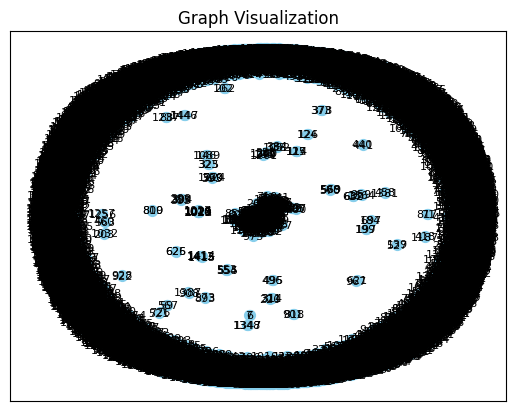

In [28]:
pos = nx.spring_layout(G)  # Positioning nodes using spring layout algorithm

# Plotting nodes
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=50)

# Plotting edges
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5)

# Displaying labels (optional)
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')

# Display the plot
plt.title("Graph Visualization")
plt.show()


In [29]:
# Laplacian matrix
L = nx.laplacian_matrix(G).toarray()

# Spectral Learning and Eigen Feature Representations

# Eigen decomposition
eigenvalues, eigenvectors = np.linalg.eigh(L)

# Sort eigenvalues and corresponding eigenvectors
sorted_indices = np.argsort(eigenvalues)
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# Select dominant eigenvectors (adjust the number as needed)
global num_eigenvectors
num_eigenvectors = 10
dominant_eigenvectors = eigenvectors[:, :num_eigenvectors]

# Eigen Feature Representations
global eigen_feature_representations
eigen_feature_representations =fractional_matrix_power(L, -0.5) @ dominant_eigenvectors



Here, we will be tokenizing the sentences.

In [30]:
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

#defining the parameters
num_classes = 1
embedding_dim = 100

# Assuming df['video.tags'] is your text data, we  tokenize the input dataset into tokens for the CNN model
#Tokenizer Initialization and Fitting:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_combined)

#Vocabulary Size and Maximum Sequence Length Calculation:
vocab_size = len(tokenizer.word_index) + 1
max_sequence_length = max(x_combined.apply(lambda x: len(x.split())))

#Texts to Sequences:
sequences = tokenizer.texts_to_sequences(x_combined)

#Padding Sequences
data = pad_sequences(sequences, maxlen=max_sequence_length)


In [31]:

# Assuming 'text' is your input data and 'label' is your target variable
X = data   #data
y = y_combined.values           #labels

# Convert labels to numerical format using LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Integrate with Cross-Domain Transfer Learning

# Concatenate eigen feature representations with existing data
X_train_with_graph = np.hstack((X_train, eigen_feature_representations[:len(X_train)]))
X_test_with_graph = np.hstack((X_test, eigen_feature_representations[len(X_train):]))

*******************************************************************************************************************************

*******************************************************************************************************************************

In [194]:
#building a basic CNN without DANN
# Define the model
model = Sequential()

# Embedding layer: Converts words into dense vectors of fixed size
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))

# Convolutional layer with max pooling
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())

# Fully connected layers for classification
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=num_classes, activation='softmax'))


In [195]:

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [199]:
# Train the model and display the activations after each epoch
start_time = time.time()
history = model.fit(X_train, y_train, epochs=1, validation_data=(X_test, y_test))
end_time = time.time()

338/338 [==============================] - 9s 28ms/step - loss: 0.0000e+00 - accuracy: 0.0346 - val_loss: 0.0000e+00 - val_accuracy: 0.0411


In [200]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('Test accuracy:', test_acc)
print('Time elapsed: ', end_time - start_time)

85/85 - 1s - loss: 0.0000e+00 - accuracy: 0.0411 - 778ms/epoch - 9ms/step
Test accuracy: 0.04109589010477066
Time elapsed:  9.461171865463257


*******************************************************************************************************************************

*******************************************************************************************************************************

In [ ]:
#Applying DANN

In [183]:
# Define the Feature Extractor
def build_feature_extractor(vocab_size,embedding_dim,max_sequence_length):
    model = models.Sequential([
        layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
        layers.Conv1D(filters=128, kernel_size=5, activation='relu'),
        layers.GlobalMaxPooling1D()
    ])
    return model

In [184]:
# Define the Label Predictor
def build_label_predictor(num_classes):
    model = models.Sequential([
        Dense(units=num_classes, activation='softmax',name='output')
    ])
    return model

In [185]:
# Define the Domain Predictor
def build_domain_predictor():
    model = models.Sequential([
        layers.Dense(64,activation='relu',name='dense_1'),
        layers.Dense(1,activation='sigmoid',name='dense_2')
    ])
    return model

In [186]:
# Build the complete DANN model
def build_dann(vocab_size,embedding_dim,max_sequence_length, num_classes,num_eigenvectors):
    feature_extractor = build_feature_extractor(vocab_size,embedding_dim,max_sequence_length)
    label_predictor = build_label_predictor(num_classes)
    domain_predictor = build_domain_predictor()

    # Define inputs
    input_data = layers.Input(shape=(max_sequence_length + num_eigenvectors,))
    label = layers.Input(shape=(num_classes,))
    domain_label = layers.Input(shape=(1,))

    # Feature extractor output
    feature_output = feature_extractor(input_data)

    # Label prediction branch
    label_output = label_predictor(feature_output)

    # Domain prediction branch
    domain_output = domain_predictor(feature_output)

    dann_model = models.Model(inputs=[input_data, label, domain_label],
                              outputs=[label_output, domain_output])

    return dann_model

In [187]:
# Define loss functions
def label_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred)

def domain_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred)

In [188]:
# Build and compile the DANN model
dann_model = build_dann(vocab_size,embedding_dim,max_sequence_length, num_classes,num_eigenvectors)

dann_model.compile(optimizer='Adam',
                   loss=[label_loss, domain_loss],
                   loss_weights=[1.0,0.1])

In [189]:
x_combined.shape

(13501,)

In [158]:
# One-hot encode the train labels
#shape of x_combined.shape is (13501,) initially despite having 3 classes
# it means that it contains class labels as integers rather than being one-hot encoded.
y_combined = tf.keras.utils.to_categorical(y_combined, 2) 

ValueError: invalid literal for int() with base 10: 'AppetizersX'

In [190]:
# Train the DANN

start_time = time.time()

dann_model.fit([X_train_with_graph, y_train, domain_labels_combined[:len(X_train)]],
                          [y_train, domain_labels_combined[:len(X_train)]],
                          epochs=1)

end_time = time.time()

ValueError: in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer 'conv1d_2' (type Conv1D).
    
    Negative dimension size caused by subtracting 5 from 1 for '{{node model_2/sequential_6/conv1d_2/Conv1D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](model_2/sequential_6/conv1d_2/Conv1D/ExpandDims, model_2/sequential_6/conv1d_2/Conv1D/ExpandDims_1)' with input shapes: [?,1,1,100], [1,5,100,128].
    
    Call arguments received by layer 'conv1d_2' (type Conv1D):
      • inputs=tf.Tensor(shape=(None, 1, 100), dtype=float32)
